In [1]:
# TODO:
# spellcheck

# Sensitivity Analysis Made Easy with the EMA Workbench

Google Colab version

This is the main notebook of the workshop on *sensitivity analysis* (SA) at the Social Simulation Festival 2021. Here we will demonstrate how to do Variance-based SA also know as [Sobol SA](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) on a relatively simple model [virus on network](https://ccl.northwestern.edu/netlogo/models/VirusonaNetwork). The idea is that you reuse (read copy-paste) this code your own model. Therefore, we tried to keep simple and avoid extensive side steps from.

This notebook is tuned to be run on [Google Colab](https://colab.research.google.com/) and has a couple of extra lines of code. If you want to use it on your local machine please use `sa_demo_local_machine.ipynb`.

The core packages used in this notebook are [Mesa](https://mesa.readthedocs.io/en/stable/) to define an ABM model in Python, [EMA Workbench](https://emaworkbench.readthedocs.io/en/latest/) to design and run experiments, [SALib](https://salib.readthedocs.io/en/latest/) to conduct SA (within EMA Workbench). Also, we used one pretty plotting function of [pyNetLogo](https://pynetlogo.readthedocs.io/en/latest/).

The notebook follows a simplified SA workflow and has 5 sections-steps:

0. Install and import all necessary packages,
1. Load and parametrize the model,
2. Design and run experiments,
3. Do SA,
4. Visualize SA outcomes.

## 0. Installations and imports

In [2]:
# Clone the repo to make its file available for Google Colab
!git clone https://github.com/BROSE-Uninc/SSF2021.git

fatal: destination path 'SSF2021' already exists and is not an empty directory.


In [3]:
# Install necessary packages
!pip install ema_workbench mesa ipyparallel SALib &> /dev/null

In [4]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

# Import EMA Workbench modules
from ema_workbench import ReplicatorModel, RealParameter, BooleanParameter, IntegerParameter, Constant, TimeSeriesOutcome, perform_experiments, save_results, ema_logging

# Initialize logger to keep track of experiments run
ema_logging.log_to_stderr(ema_logging.INFO)

# Import Mesa virus on network model
from SSF2021.src import model

/Users/kleinraphael/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/em_framework/optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


## 1. Load & parametrize the model

In [5]:
# TODO:
# explain what is about to happen here more extensively
# shortly explain the model

The very first step of SA with EMA Workbench is to define or "load" the model as a function. That is, EMA Workbench treats all models as functions (read black boxes). They suppose to have **inputs** (parameters, constants, uncertainties and policy levers) and **outputs** (outcomes, KPIs). The model structure is not interesting for EMA Workbench. It may be something simple as `def func(x)` which just returns x + 1. 

One important feature of our model is that it has *time* component.  

In [6]:
# setting up the virus on network model simulation as a function
def model_virus_on_network(num_nodes=1, 
                           avg_node_degree=1, 
                           initial_outbreak_size=1, 
                           virus_spread_chance=1, 
                           virus_check_frequency=1, 
                           recovery_chance=1, 
                           gain_resistance_chance=1,
                           steps=10):
    
    from src import model
    
    # Initialising the model
    virus_on_network = model.VirusOnNetwork(num_nodes=num_nodes, 
                                            avg_node_degree=avg_node_degree, 
                                            initial_outbreak_size=initial_outbreak_size, 
                                            virus_spread_chance=virus_spread_chance, 
                                            virus_check_frequency=virus_check_frequency, 
                                            recovery_chance=recovery_chance, 
                                            gain_resistance_chance=gain_resistance_chance)
                
    # Run the model steps times
    virus_on_network.run_model(steps)
    
    # Get model outcomes
    outcomes = virus_on_network.datacollector.get_model_vars_dataframe()
    
    # Return model outcomes
    return {'TIME' : list(range(steps + 1)),
            "Infected" : outcomes["Infected"].tolist(),
            "Susceptible" : outcomes["Susceptible"].tolist(),
            "Resistant" : outcomes["Resistant"].tolist()}
    

Now, let's parametrize and test out our Mesa model. What suppose to happen? First, no errors :-) Second, after we run function `model_virus_on_network` it has to give us a set of model outcomes. Let's try.

In [7]:
# Parametrize the model
num_nodes = 30
avg_node_degree = 3
initial_outbreak_size = 1
virus_spread_chance = 0.4
virus_check_frequency = 0.2
recovery_chance = 0.4
gain_resistance_chance = 0.3
steps = 10

model_virus_on_network(num_nodes=num_nodes, 
                       avg_node_degree=avg_node_degree, 
                       initial_outbreak_size=initial_outbreak_size, 
                       virus_spread_chance=virus_spread_chance, 
                       virus_check_frequency=virus_check_frequency, 
                       recovery_chance=recovery_chance, 
                       gain_resistance_chance=gain_resistance_chance,
                       steps=steps)

{'TIME': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Infected': [1, 7, 15, 15, 19, 21, 22, 23, 20, 20, 19],
 'Susceptible': [29, 23, 15, 13, 9, 7, 5, 3, 4, 4, 4],
 'Resistant': [0, 0, 0, 2, 2, 2, 3, 4, 6, 6, 7]}

### Design EMA experiments

In this part, we define the experiments. First, we initialise the workbench, then we define the parameters that need to change from experiment to experiment, we define the constant parameters (number of steps and initial outbreak) and finally we define the output parameters.

In [8]:
# loading the model into the EMA workbench
model = ReplicatorModel('virusnetwork', function=model_virus_on_network)

In [9]:
# defining ranges for the parameters to be varied
# model.uncertainties = [IntegerParameter("num_nodes", 10, 100),
#                        IntegerParameter("avg_node_degree", 2, 8),
#                        RealParameter("virus_spread_chance", 0.1, 1),
#                        RealParameter("virus_check_frequency", 0.1, 1),
#                        RealParameter("recovery_chance", 0.1, 1),
#                        RealParameter("gain_resistance_chance", 0.1, 1)]

In [10]:
# # defining ranges for the parameters to be varied
model.uncertainties = [RealParameter("virus_check_frequency", 0.1, 1),
                       RealParameter("recovery_chance", 0.1, 1),
                       RealParameter("gain_resistance_chance", 0.1, 1)]

In [11]:
# defining the parameters that will remain constant
initial_outbreak_size = 1
steps = 30
num_nodes = 30
avg_node_degree - 3
virus_spread_chance = 0.2
model.constants = [Constant("initial_outbreak_size", initial_outbreak_size),
                   Constant('steps', steps),
                   Constant("num_nodes", num_nodes),
                   Constant("avg_node_degree", avg_node_degree),
                   Constant("virus_spread_chance", virus_spread_chance)]

In [12]:
# defining the outputs of interests from the model
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('Infected'),
                  TimeSeriesOutcome('Susceptible'),
                  TimeSeriesOutcome('Resistant')]

In [13]:
# defining the number of replications
model.replications = 10

### Perform EMA experiments

In this part we run the EMA experiments using the previously set parameters. We then store the results.

In [14]:
# running the EMA experiments with the aforementioned parameters and outputs
results = perform_experiments(model, 100)

# opening the results
experiments, outcomes = results

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [15]:
# TODO:
# Save

### Process outcomes
In this part we reshape the results so that they can be more easily plotted later on.

In [16]:
outcomes[random.choice(list(outcomes))].shape

(100, 10, 31)

In [17]:
#get shape of every outcome (should all be identical?)
# for k in list(outcomes):
#     print(outcomes[k].shape)

In [18]:
outcomes_2D = {key:np.mean(outcomes[key],axis=1) for key in outcomes.keys()}
results_2D = (experiments.copy(), outcomes_2D)

In [19]:
outcomes_2D[random.choice(list(outcomes))].shape

(100, 31)

### Visualize outcomes
In this part, we plot the three different model outcomes.

In [20]:
from ema_workbench.analysis.plotting import lines

/Users/kleinraphael/opt/anaconda3/lib/python3.8/site-packages/ema_workbench/analysis/prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


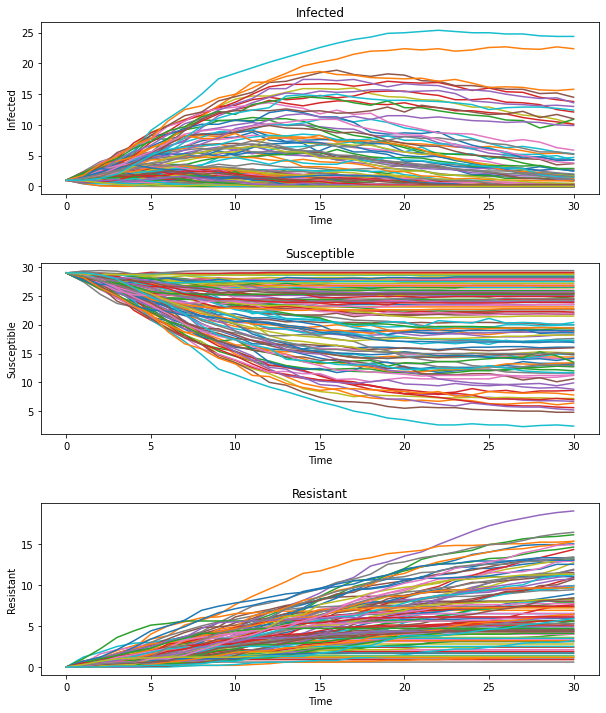

In [21]:
# plotting all of the results
plt.rcParams['figure.figsize'] = [10, 12]

figure = lines(experiments, outcomes_2D) #show lines, and end state density
plt.show()

### Sensitivity analysis

In [22]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

In [23]:
sa_results = perform_experiments(model, scenarios=100, uncertainty_sampling='sobol')
sa_experiments, sa_outcomes = sa_results

[MainProcess/INFO] performing 800 scenarios * 1 policies * 1 model(s) = 800 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 560 cases completed
[MainProcess/INFO] 640 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] experiments finished


##### Sample size for Sobol
To calculate first-order, second-order and total sensitivity indices, 
this gives a sample size of n(2p+2), where p is the number of input parameters, 
and n is a baseline sample size which should be large enough to stabilize the estimation of the indices.
from https://pynetlogo.readthedocs.io/en/latest/_docs/SALib_ipyparallel.html#Using-SALib-for-sensitivity-analysis

In [24]:
# selecting only the first axis of the result array (why?)
sa_outcomes_2D = {key:np.mean(sa_outcomes[key],axis=1) for key in sa_outcomes.keys()}
sa_results_2D = (sa_experiments.copy(), sa_outcomes_2D)

In [25]:
# normalising the number of resistant agents
# normalized_resistant = 
#     (sa_outcomes_2D['Resistant'][:,-1] / sa_experiments['num_nodes']).to_numpy()
normalized_resistant = (sa_outcomes_2D['Resistant'][:,-1] / num_nodes)
normalized_resistant

array([0.28      , 0.54      , 0.31333333, 0.39333333, 0.23333333,
       0.41666667, 0.43      , 0.23333333, 0.45333333, 0.24333333,
       0.43666667, 0.23666667, 0.25666667, 0.12      , 0.22      ,
       0.25      , 0.31333333, 0.22666667, 0.25      , 0.57333333,
       0.41333333, 0.47      , 0.12      , 0.53333333, 0.22666667,
       0.18333333, 0.42333333, 0.03666667, 0.30666667, 0.05666667,
       0.32333333, 0.31666667, 0.28333333, 0.43666667, 0.36      ,
       0.20333333, 0.34      , 0.09666667, 0.30666667, 0.36666667,
       0.11      , 0.08      , 0.14      , 0.29333333, 0.42333333,
       0.25666667, 0.11333333, 0.36666667, 0.45      , 0.22666667,
       0.17333333, 0.3       , 0.49333333, 0.08333333, 0.10666667,
       0.20333333, 0.01666667, 0.08      , 0.10333333, 0.03      ,
       0.19      , 0.14333333, 0.06      , 0.15666667, 0.10666667,
       0.29      , 0.21666667, 0.15333333, 0.19      , 0.44      ,
       0.43333333, 0.20333333, 0.12333333, 0.12      , 0.52333

In [26]:
# performing the sobol analysis
sa_problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(sa_problem, normalized_resistant,
                   calc_second_order=True, print_to_console=False)

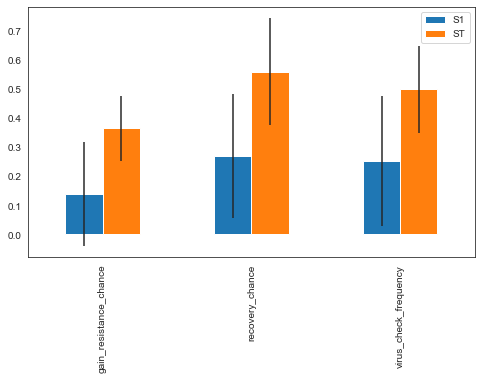

In [27]:
# plotting the results from the analysis
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=sa_problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [28]:
Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(Si_filter, index=sa_problem['names'])

In [29]:
from SSF2021.src.plot import plot_sobol_indices

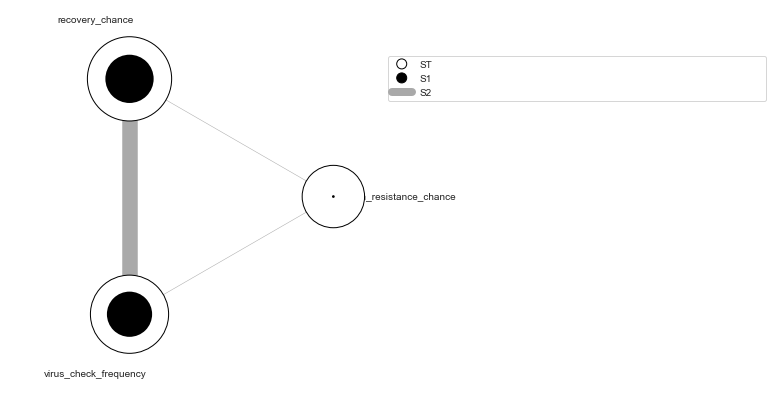

In [30]:
sns.set_style('whitegrid')
fig = plot_sobol_indices(Si, sa_problem, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)
plt.show()